# SegNet 2 Development
* this model aims to test the segnet2 implementation of SegNet

# Jump down to learning rate testing

[Click here](#learning_rate)

# Jump down to final testing with optimised learning rate and tensorboard analytics
[Click here](#good_train)


In [1]:
#################### Imports #########################
from __future__ import print_function, division
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
from collections import OrderedDict
import time
import numpy as np
from torch.autograd import Variable
from pathlib import Path
from PIL import Image
# imports copied for loading in data
import os
import pandas as pd
#from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode
multiGPU = False
##### Tensor board requirements
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [57]:
%pip install tensorboard 
%pip3 install tensorboard  
%pip install --upgrade tensorboard 
%pip install --upgrade torch

  Using cached tensorboard-2.3.0-py3-none-any.whl (6.8 MB)
  Using cached absl_py-0.10.0-py3-none-any.whl (127 kB)
     |████████████████████████████████| 88 kB 6.6 MB/s  eta 0:00:01
     |████████████████████████████████| 298 kB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 49.1 MB/s eta 0:00:01
  Using cached tensorboard_plugin_wit-1.7.0-py3-none-any.whl (779 kB)
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%pip3` not found.


In [2]:
# define variables if GPU is to be used
if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
    use_gpu = False
FloatTensor = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_gpu else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_gpu else torch.ByteTensor
Tensor = FloatTensor

Using GPU


In [9]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

In [3]:
######## unedited data class
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [4]:
###### unedited import
base_path = Path('38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)


8400

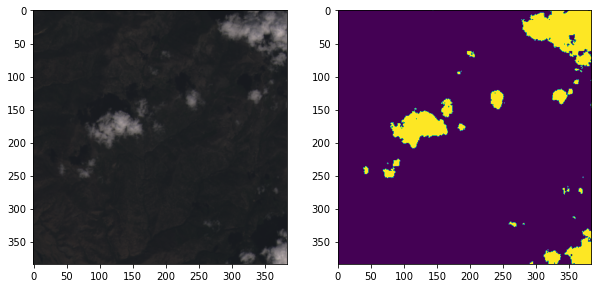

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(150))
ax[1].imshow(data.open_mask(150))

In [5]:
####### Split the data
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True)
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([4, 4, 384, 384]), torch.Size([4, 384, 384]))

In [7]:
# import segnet 2
from segnet2.py import SegNet

In [12]:
################ Initialise Model ###############
learning_rate = 1e-3
num_classes = 2      # assuming cloud and non cloud
num_channels = 4     # for the cloud data, for now
model = SegNet(num_channels,num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)                  
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
  model.cuda()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

In [13]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape
pred = model(xb.cuda())
pred.shape

torch.Size([4, 2, 384, 384])

# Training Function Source
https://www.kaggle.com/cordmaur/38-cloud-simple-unet

In [8]:
######## train function 
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, scheduler, acc_fn, epochs=1):
    start = time.time()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [16]:
#### training attempt 1

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, valid_loss = train(model, train_dl, valid_dl, loss_fn, opt,exp_lr_scheduler, acc_metric, epochs=5)



Epoch 4/4
----------
valid Loss: 0.3092 Acc: 0.8421784043312073
----------
Training complete in 68m 25s


In [9]:
torch.cuda.is_available()

True

# Training Attempt 1
* The model is functioning and the training loss seems to be going down quite rapidly
* This was just to see how the model is working

* batch size 4 
* epochs 5
* starting learning rate 0.001

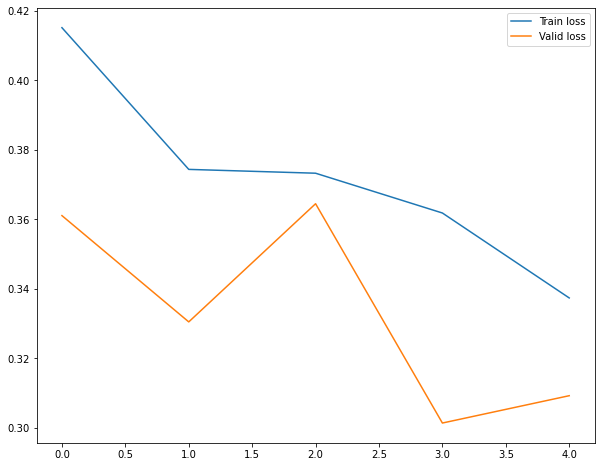

In [17]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [18]:
######## now to view some of the predictions
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [29]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

predb.shape

torch.Size([4, 2, 384, 384])

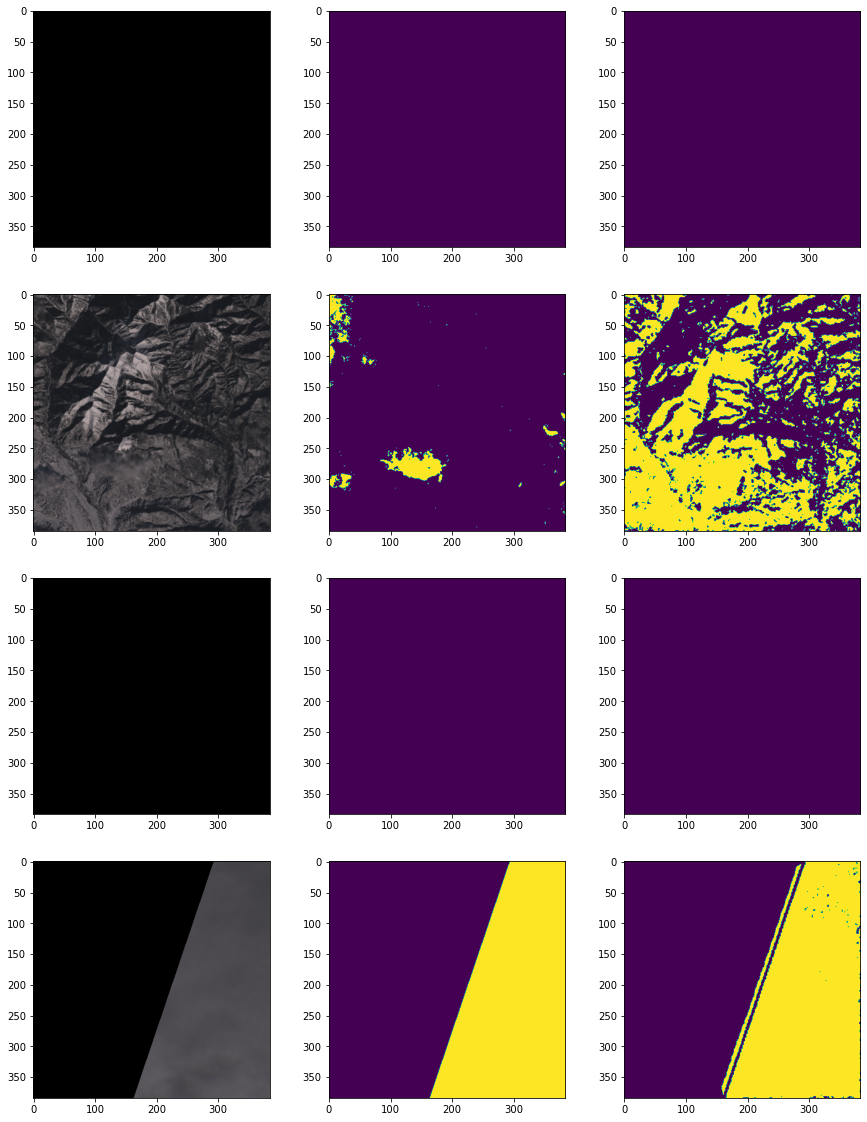

In [28]:

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

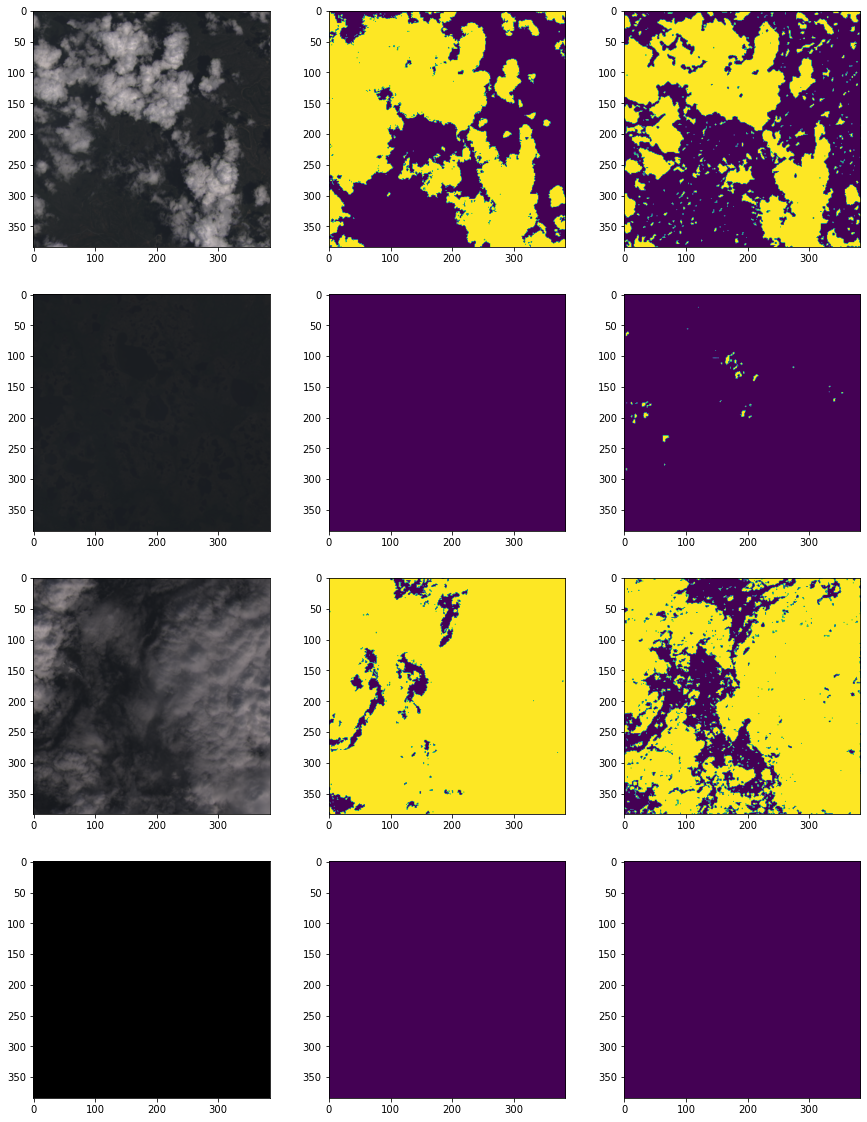

In [30]:
bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

# Training Attempt 2
* batch size 12
* epochs 50

In [11]:
####### Split the data
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 4, 384, 384]), torch.Size([12, 384, 384]))

In [13]:
num_classes = 2   # assuming cloud and non cloud
num_channels = 4  # for the cloud data, for now
model = SegNet(num_channels,num_classes)

if torch.cuda.is_available():
  model.cuda()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)


loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

train_loss, valid_loss = train(model, train_dl, valid_dl, loss_fn, opt,exp_lr_scheduler, acc_metric, epochs=50)



Epoch 49/49
----------
valid Loss: 0.5471 Acc: 0.7293245792388916
----------
Training complete in 545m 23s


In [14]:
######## Save the model 

# Specify a path
PATH = "SegNet2_state_dict_model.pt"


torch.save(model.state_dict(), PATH)     # saves the model wegiths


# To load
'''
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''


PATH = "SegNet2_model.pt"



############# Alternatively

torch.save(model, PATH)                  # saves the model weighs ane model
# To load
'''
model = torch.load(PATH)
model.eval()
'''

'\nmodel = torch.load(PATH)\nmodel.eval()\n'

In [25]:
########## Assess the results

def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [26]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

predb.shape

torch.Size([12, 2, 384, 384])

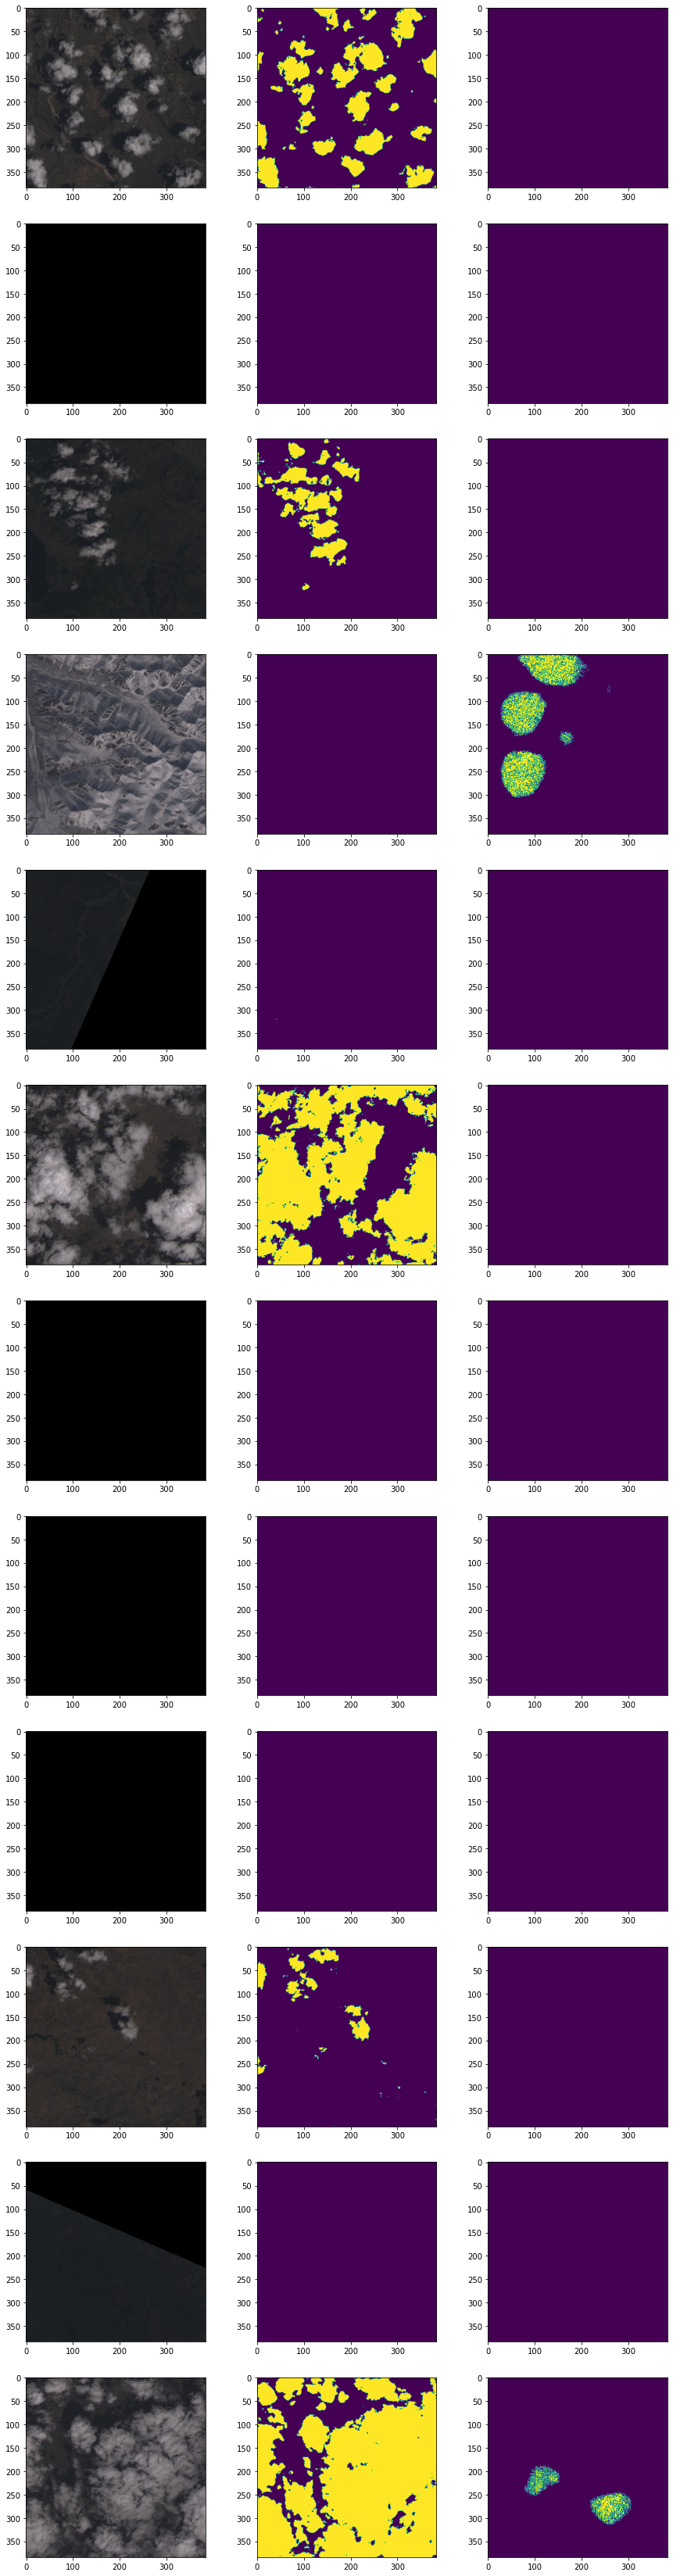

In [27]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

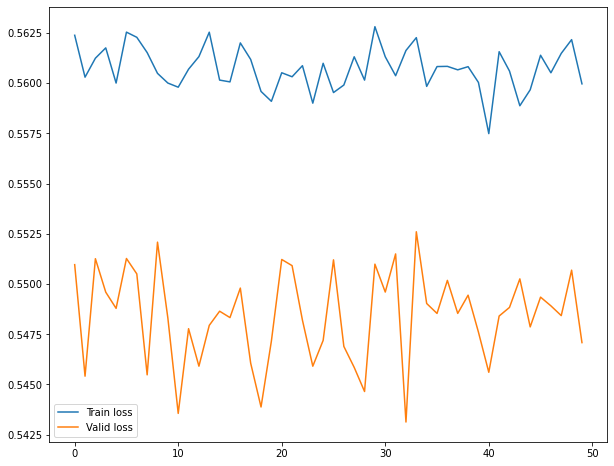

In [18]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

# Training Attempt 3
* the model performed poorly
* with a batch size of 4 it seemed fine for 5 epochs, but this setup was surpurisingly bad

Now
* batch size 4 
* epochs 20

In [28]:
epochs=20

####### Split the data
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True)
xb, yb = next(iter(train_dl))


num_classes = 2 # assuming cloud and non cloud
num_channels = 4 # for the cloud data, for now
model = SegNet(num_channels,num_classes)

if torch.cuda.is_available():
  model.cuda()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)


loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

train_loss, valid_loss = train(model, train_dl, valid_dl, loss_fn, opt,exp_lr_scheduler, acc_metric, epochs=epochs)


Epoch 9/19
----------
valid Loss: 0.5206 Acc: 0.6912612915039062
----------
Epoch 10/19
----------
Current step: 100  Loss: 0.6713401079177856  Acc: 0.4910600483417511  AllocMem (Mb): 718.0927734375
Current step: 200  Loss: 0.43983617424964905  Acc: 0.8782569169998169  AllocMem (Mb): 718.0927734375
Current step: 300  Loss: 0.46975237131118774  Acc: 0.7546234130859375  AllocMem (Mb): 718.0927734375
Current step: 400  Loss: 0.5932571887969971  Acc: 0.6931220293045044  AllocMem (Mb): 718.0927734375
Current step: 500  Loss: 0.6760380268096924  Acc: 0.4444088339805603  AllocMem (Mb): 718.0927734375
Current step: 600  Loss: 0.9781833291053772  Acc: 0.1745792031288147  AllocMem (Mb): 718.0927734375
Current step: 700  Loss: 0.602904200553894  Acc: 0.5373857617378235  AllocMem (Mb): 718.0927734375


KeyboardInterrupt: 

In [30]:
######## Save the model 

# Specify a path
PATH = 'Segmentation Model Artifacts/SegNet2_state_dict_model_bs_4_bad.pt'


torch.save(model.state_dict(), PATH)     # saves the model wegiths


# To load
'''
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''


PATH = 'Segmentation Model Artifacts/SegNet2_model_bs_4_bad.pt'



############# Alternatively

torch.save(model, PATH)                  # saves the model weighs ane model
# To load
'''
model = torch.load(PATH)
model.eval()
'''

'\nmodel = torch.load(PATH)\nmodel.eval()\n'

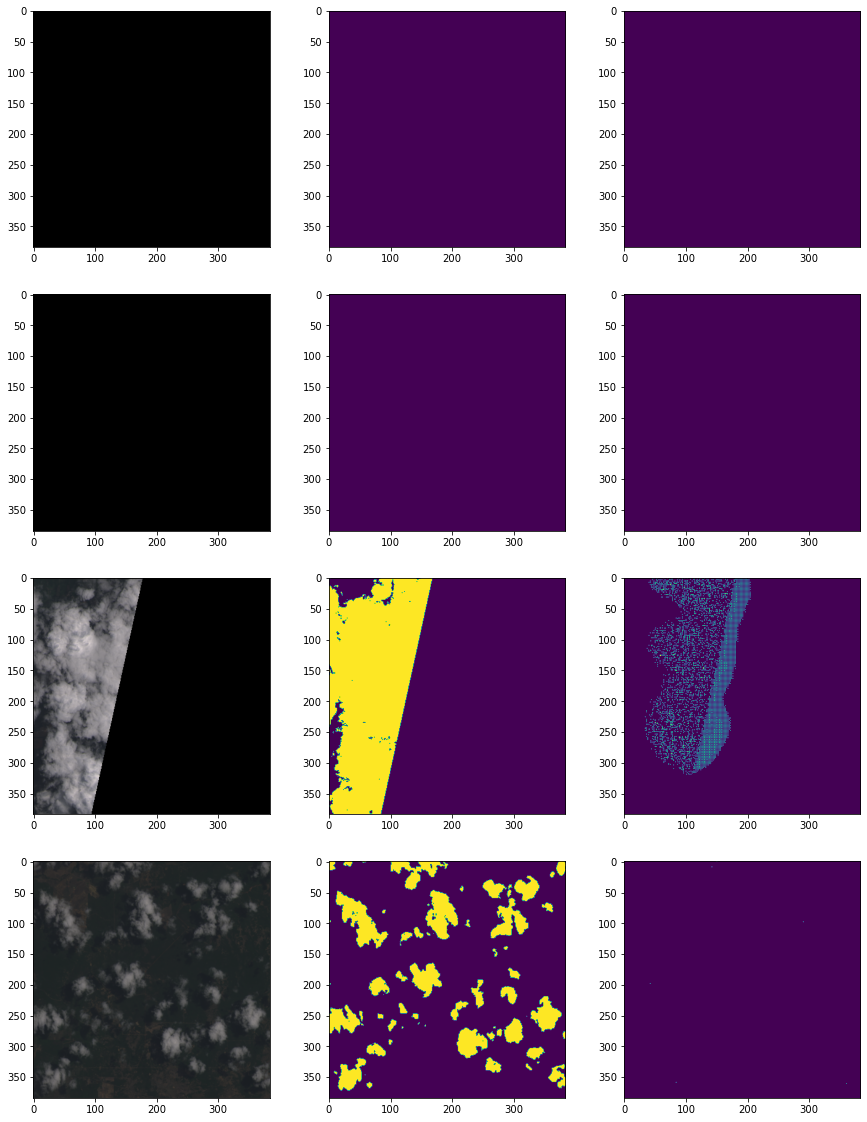

In [37]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

predb.shape

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

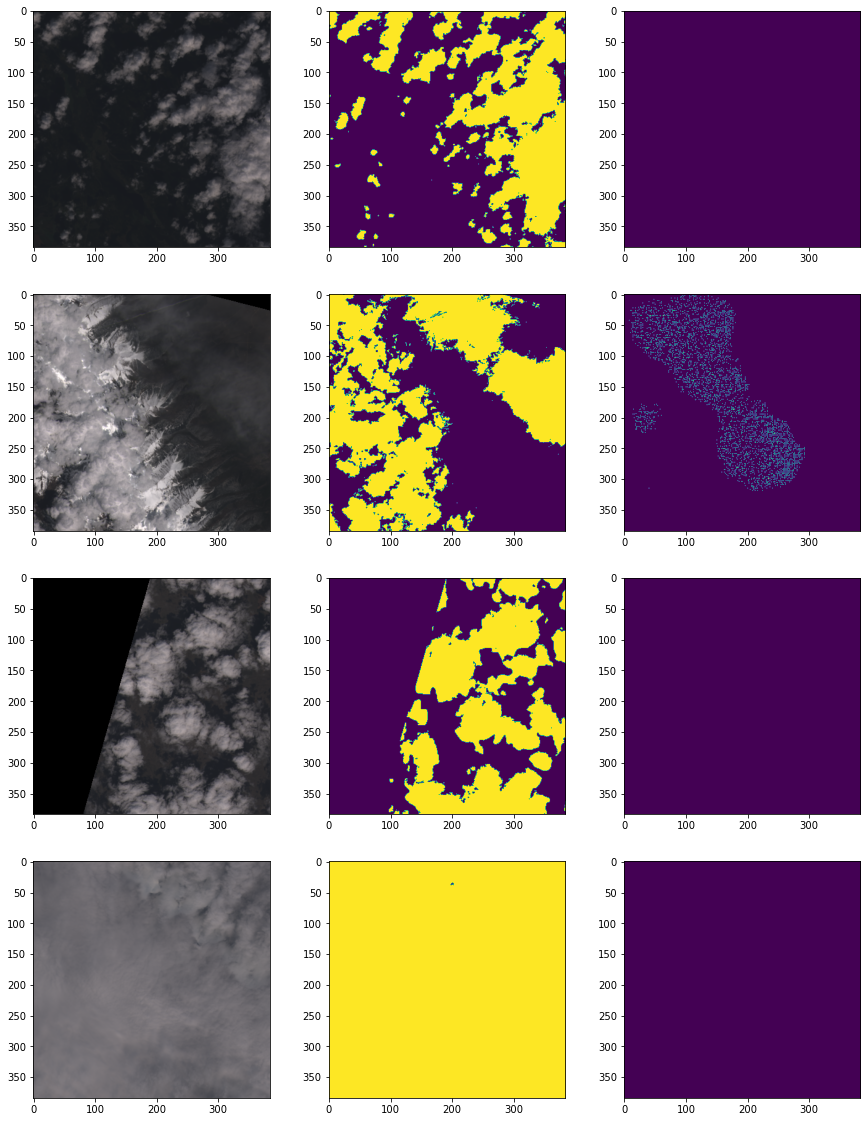

In [36]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

<a id='current_progress'></a>

# Diagnosis
Why was the model performing so poorly?
* In the first run the model was improving quite well in the 5 epochs it trained for
* The reason may be that in the above code, the scheduler for the 5 epoch run was not properly defined, so it was not working during that run. Therefore, it appears that includig the scheduler is actually worsening the training of the SegNet

# Training Run - w. Tensorboard & no scheduler
* In this run the model will be trained without a scheduler and using the tensorboard tools to visualise the results.

In [6]:
############# Code for setting up the data from scratch ############
# had it all over the place previously, was time to clean it up
base_path = Path('38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')

batch_size = 4

train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [69]:
############# Initialise the model #############

learning_rate = 1e-3
num_classes = 2 # assuming cloud and non cloud
num_channels = 4 # for the cloud data, for now
model = SegNet(num_channels,num_classes)
opt = optim.Adam(model.parameters(), lr=learning_rate)                  

if torch.cuda.is_available():
  model.cuda()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)


In [96]:
######## Add the model to the tensorboard to visualise
writer = SummaryWriter('runs/SegNet2/Training Without Scheduler Attempt 1')

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

# adds a visualisation of the model archetecture
writer.add_graph(model, xb.cuda())

In [99]:
############# Training funciton with Tensorbaord analytics in built #############


import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()

    train_loss, valid_loss = [], []

    best_acc = 0.0
    summary_acc = 0.0
    summary_loss = 0.0
    n_total_steps = len(train_dl)

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 
                
                # metrics for tensorbaord 
                summary_acc += acc
                summary_loss += loss

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())
                    writer.add_scalar('loss', running_loss / 100, epoch * n_total_steps + step)
                    writer.add_scalar('accuracy', summary_acc / 100, epoch * n_total_steps + step)
                    summary_acc = 0.0
                    summary_loss = 0.0

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

In [ ]:
################# Train model #############################    kernal shut down randomly
epochs = 50

loss_fn = nn.CrossEntropyLoss()

train_loss, valid_loss = train(model, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=epochs)

Epoch 20/49
----------
valid Loss: 0.1486 Acc: 0.9436662793159485
----------
Epoch 21/49
----------
Current step: 100  Loss: 0.2618374228477478  Acc: 0.8844197392463684  AllocMem (Mb): 1159.2841796875
Current step: 200  Loss: 0.5286723375320435  Acc: 0.7813720703125  AllocMem (Mb): 1159.2841796875
Current step: 300  Loss: 0.034070007503032684  Acc: 0.9936354160308838  AllocMem (Mb): 1159.2841796875
Current step: 400  Loss: 0.1917749047279358  Acc: 0.9262203574180603  AllocMem (Mb): 1159.2841796875
Current step: 500  Loss: 0.07730165123939514  Acc: 0.975389301776886  AllocMem (Mb): 1159.2841796875
Current step: 600  Loss: 0.07866011559963226  Acc: 0.9818013310432434  AllocMem (Mb): 1159.2841796875
Current step: 700  Loss: 0.08488147705793381  Acc: 0.979295551776886  AllocMem (Mb): 1159.2841796875
Current step: 800  Loss: 0.036619290709495544  Acc: 0.9903242588043213  AllocMem (Mb): 1159.2841796875
Current step: 900  Loss: 0.5001461505889893  Acc: 0.7892879843711853  AllocMem (Mb): 1159.

In [ ]:
##################### Save the model ######################

# Specify a path
PATH = 'Segmentation Model Artifacts/SegNet2/SegNet2_state_dict_model_no_scheduler.pt'

torch.save(model.state_dict(), PATH)     # saves the model wegiths



PATH = 'Segmentation Model Artifacts/SegNet2/SegNet_model_no_scheduler.pt'

torch.save(model, PATH)                  # saves the model weighs and model



## Now to visualise the results of this training run (no scheduler)
* The inclusion of the scheduler in the longer training runs seemed to compromise the model
* Here is the model, trained on 50 epochs withouth the scheduler

### Note
* There was a bug in the tensorbaord portion of the training function for this run

In [ ]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

predb.shape

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [ ]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [ ]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

# Conclusion
* The model training was interrupted by the kernal, but from the progress, the current hyperparamter setting without the scheduler was working quite well
* Before blindly trying ot run the training again, I will attempt to use a hyperparameter tuning library and then train the model on the best settings
* This will provide a platform for tuning the other models too

<a id='learning_rate'></a>
# Learning Rate Finder
https://github.com/davidtvs/pytorch-lr-finder
* We shall run this first and then try the hyperparameter training tool

In [4]:
%pip install torch-lr-finder

  Using cached torch_lr_finder-0.2.1-py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.


## Tweaked version from fastai
"Increases the learning rate in an exponential manner and computes the training loss for each learning rate. lr_finder.plot() plots the training loss versus logarithmic learning rate."

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-03


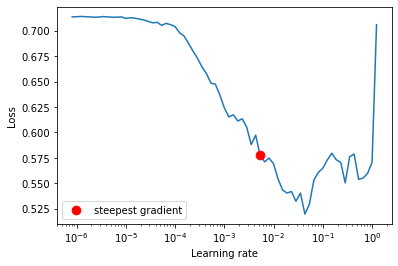

In [7]:
from torch_lr_finder import LRFinder


num_classes = 2 # assuming cloud and non cloud
num_channels = 4 # for the cloud data, for now
model = SegNet(num_channels,num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# Leslie Smith's approach
Increases the learning rate linearly and computes the evaluation loss for each learning rate. lr_finder.plot() plots the evaluation loss versus learning rate. This approach typically produces more precise curves because the evaluation loss is more susceptible to divergence but it takes significantly longer to perform the test, especially if the evaluation dataset is large.

## Stopped Early
* In the interest of time, the above analysis will be used for selecting the learning rate

In [12]:
num_classes = 2 # assuming cloud and non cloud
num_channels = 4 # for the cloud data, for now
model = SegNet(num_channels,num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, val_loader=valid_dl, end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

KeyboardInterrupt: 

<a id='good_train'></a>
# Training Attempt (no scheduler, optimised learning rate)

In [13]:
############# re-import data ############

# this was done since the kernal had been dead previously

base_path = Path('38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')

batch_size = 4

train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [18]:
############# Initialise the model #############

learning_rate = 5.34E-03 # optimised learning rate
num_classes = 2 # assuming cloud and non cloud
num_channels = 4 # for the cloud data, for now
model = SegNet(num_channels,num_classes)
opt = optim.Adam(model.parameters(), lr=learning_rate)                   

if torch.cuda.is_available():
  model.cuda()

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)


In [19]:
######## Add the model to the tensorboard to visualise
writer = SummaryWriter('runs/SegNet2/Training with opt lr')

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

# adds a visualisation of the model archetecture
writer.add_graph(model, xb.cuda())

In [20]:
############# Training funciton with Tensorbaord analytics in built #############


import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()

    train_loss, valid_loss = [], []

    best_acc = 0.0
    summary_acc = 0.0
    summary_loss = 0.0
    n_total_steps = len(train_dl)

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 
                
                # metrics for tensorbaord 
                summary_acc += acc
                summary_loss += loss

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())
                    writer.add_scalar('loss', running_loss / 100, epoch * n_total_steps + step)
                    writer.add_scalar('accuracy', summary_acc / 100, epoch * n_total_steps + step)
                    summary_acc = 0.0
                    summary_loss = 0.0

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

In [21]:
################# Train model #############################    
epochs = 50

loss_fn = nn.CrossEntropyLoss()

train_loss, valid_loss = train(model, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=epochs)


# the error below was just a mistake in the saving step, the model was successfully saved below

Epoch 49/49
----------
valid Loss: 0.1540 Acc: 0.9467735290527344
----------
Training complete in 624m 31s


FileNotFoundError: [Errno 2] No such file or directory: 'Segmentation Model Artifacts/SegNet2/SegNet2_state_dict_model_opt_lr_1.pt'

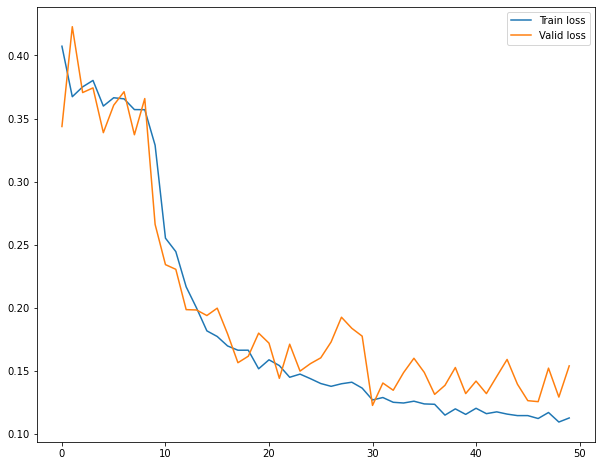

In [22]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()


import pickle
with open("segnet2_train_loss.txt", "wb") as fp:   #Pickling
    pickle.dump(train_loss, fp)

with open("segnet2_valid_loss.txt", "wb") as fp:   #Pickling
    pickle.dump(valid_loss, fp)



In [23]:
##################### Save the model ######################

# Specify a path
PATH = 'Segmentation Model Artifacts/SegNet2/SegNet2_state_dict_model_opt_lr_1.pt'

torch.save(model.state_dict(), PATH)     # saves the model wegiths



PATH = 'Segmentation Model Artifacts/SegNet2/SegNet_model_opt_lr_1.pt'

torch.save(model, PATH)                  # saves the model weights and model

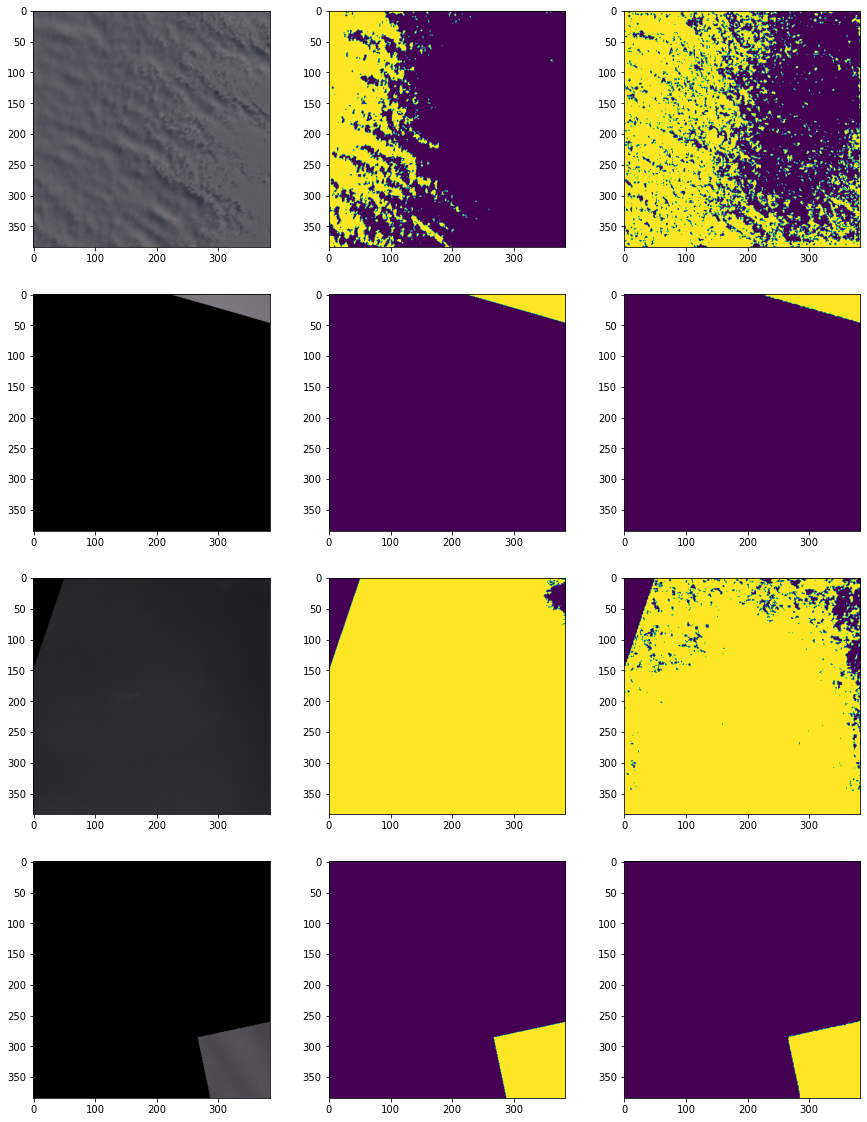

In [29]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

predb.shape

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

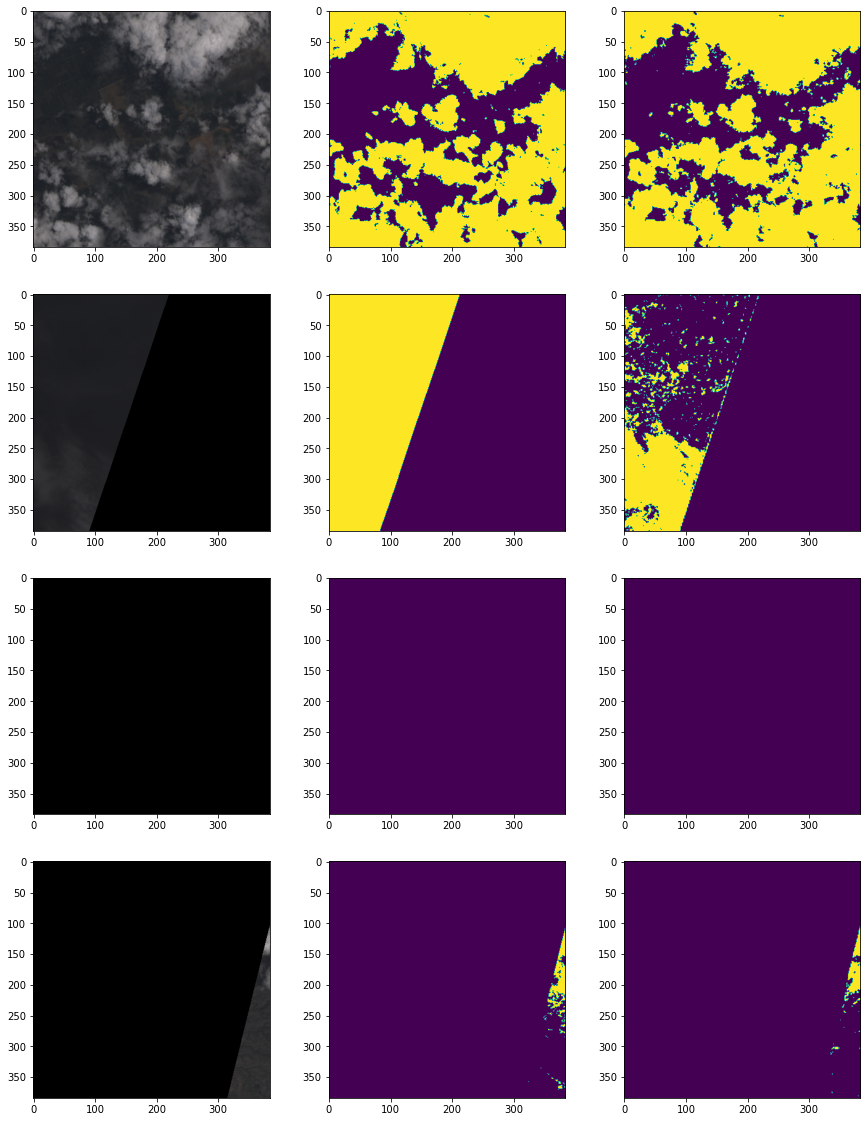

In [28]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

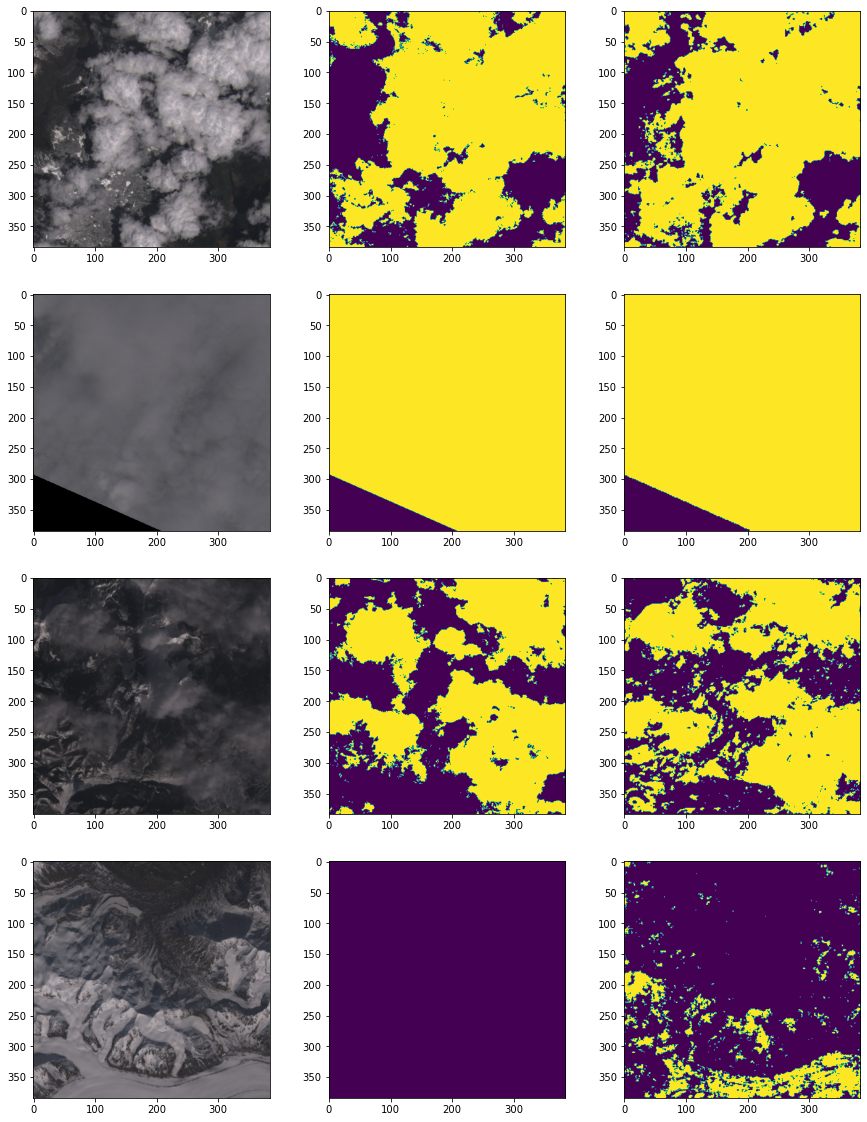

In [36]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb.cuda())

bs = 4
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [31]:
##################### Save the model, again, just in case ######################

# Specify a path
PATH = 'Segmentation Model Artifacts/SegNet2/SegNet2_model_state_dict.pt'

torch.save(model.state_dict(), PATH)     # saves the model wegiths



PATH = 'Segmentation Model Artifacts/SegNet2/SegNet2_model.pt'

torch.save(model, PATH)                  # saves the model weights and model

In [37]:
################# Saving the loss curves ##################

import pickle
with open("segnet2_train_loss.txt", "wb") as fp:   #Pickling
    pickle.dump(train_loss, fp)

with open("segnet2_valid_loss.txt", "wb") as fp:   #Pickling
    pickle.dump(valid_loss, fp)


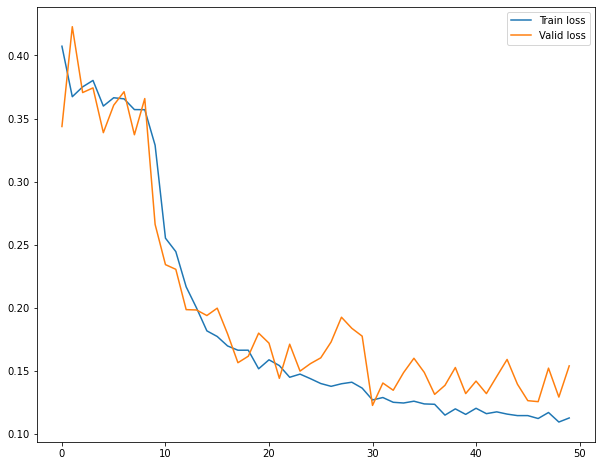

In [38]:
################ Loading the curves from the saved files ###############

with open("segnet2_train_loss.txt", "rb") as fp:   # Unpickling
    train_loss_saved = pickle.load(fp)
with open("segnet2_valid_loss.txt", "rb") as fp:   # Unpickling
    valid_loss_saved = pickle.load(fp)

plt.figure(figsize=(10,8))
plt.plot(train_loss_saved, label='Train loss')
plt.plot(valid_loss_saved, label='Valid loss')
plt.legend()

